# Practical Aspects of Neural Networks

En este notebook vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales.

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

#### **Requisito: En todos los entrenamientos se utilizará el 20% de los datos en x_train como  conjunto de datos de validación **

### Un error común con modelos de Keras

Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

```python
model = Sequential()
model.add(lo que sea)  # Definición del modelo
model.fit()
```

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con `model = Sequential()`. Si olvidamos este paso y volvemos a hacer `fit()`, el modelo seguirá entrenando por donde se quedó en el último `fit()`.

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto `history` que podéis obtener como salida del método `fit()` de Keras:

```python
history = model.fit(x_train, y_train, ...)
```

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [3]:
def plot_acc(histories, titles):
    """Imprime una gráfica mostrando las accuracies por epoch obtenidas en los entrenamientos"""
    n_imagenes_mostrar = len(histories)
    alto_imagen = 5
    ancho_imagen = alto_imagen
    
    f, axes = plt.subplots(1, n_imagenes_mostrar,
                           figsize=(n_imagenes_mostrar * ancho_imagen, alto_imagen),
                           sharey=True)

    for ax, history, title in zip(axes.flat, histories, titles):
        ax.plot(history.history['acc'])
        ax.plot(history.history['val_acc'])
        ax.set_title(title + ' Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='center right')
    
def plot_loss(histories, titles):
    """Imprime una gráfica mostrando las pérdidas por epoch obtenidas en los entrenamientos"""
    n_imagenes_mostrar = len(histories)
    alto_imagen = 5
    ancho_imagen = alto_imagen
    
    f, axes = plt.subplots(1, n_imagenes_mostrar,
                           figsize=(n_imagenes_mostrar * ancho_imagen, alto_imagen),
                           sharey=True)

    for ax, history, title in zip(axes.flat, histories, titles):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title(title + ' Model Loss')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Val'], loc='center right')

## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Funciones de activación como _sigmoid_ han dejado de utilizarse en favor de otras unidades como ReLU.

Partiendo de una red sencilla como la desarrollada [Introduction to Neural Networks with TensorFlow and Keras](../introduction-to-neural-networks/introduction-to-neural-networks.ipynb), se presenta un breve análisis comparando la utilización de unidades sigmoid y ReLU.

Antes de comenzar con el entrenamiento de los modelos, hay que preparar las variables categóricas para que Keras pueda trabajar con ellas.

In [4]:
# Conversión de las variables categóricas
n_clases = len(set(y_train).union(set(y_test)))

y_train = keras.utils.to_categorical(y_train, num_classes=n_clases)
y_test = keras.utils.to_categorical(y_test, num_classes=n_clases)

A continuación se define una función que se empleará para entrenar modelos con la misma arquitectura y facilitará la modificación de parámetros.

En todos los casos de entrenamiento las capas serán de tipo `Dense` (o *fully connected*) y se intercalarán entre capas de neuronas, una capa `BatchNormalization` para corregir posibles errores derivados de la inicialización de parámetros y mejorar la convergencia de la red y otra `Dropout` con el fin de evitar el sobreajuste del modelo.

In [5]:
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

def _generar_capa(units: int, activation: str, kernel_initializer: str):
    return Dense(units,                                  # Número de unidades de la capa
                 activation=activation,                  # Función de activación de la capa
                 input_shape=x_train[0].shape,           # Tamaño de los parámetros de entrada
                 kernel_initializer=kernel_initializer   # Inicialización de pesos
    )

def entrenar_modelo(x_train, y_train,
                    activation: str = 'relu',
                    kernel_initializer: str = 'glorot_uniform',
                    optimizer: str = 'adam',
                    epochs: int = 25,
                    porc_validacion: float = 0.20,
                    show_only_summary: bool = True):
    '''
    Función base para la construcción de modelos entrenados

    params:
        x_train: Features para el entrenamiento del modelo
        y_train: Variable objetivo para el entrenamiento del modelo
        activation: Función de activación que se usará en las capas Dense
        kernel_initializer: Estrategia para asignar los valores iniciales de los pesos
        optimizer: Función de optimización de la función de coste
        epochs: Número de épocas del entrenamiento
        porc_validacion: Porcentaje de datos empleados para el conjunto de validación del entrenamiento.
                         Los datos usados para validación no se tendrán en cuenta en el entrenamiento
        show_only_summary: Flag para no mostrar el progreso del entrenamiento y sólo mostrar un resumen
    '''
    model = Sequential()

    # Composición de la red
    model.add(_generar_capa(128, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(_generar_capa(64, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(_generar_capa(64, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(_generar_capa(32, activation=activation, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Se añade esta capa adicional para que la salida de la capa anterior
    # que devolvía un array de 2 dimensiones se aplane 
    model.add(Flatten())

    # Capa de salida
    model.add(Dense(n_clases, activation='softmax'))

    # Compilación del modelo
    model.compile(
        optimizer=optimizer,               # método de optimización de la función de coste
        loss='categorical_crossentropy',   # función de coste para variables categóricas: https://keras.io/losses/
        metrics=['accuracy']               # métrica de evaluación durante el entrenamiento
    )

    # Parámetros de entrenamiento
    batch_size = 64                     # Tamaño de los batchs
    verbose = not show_only_summary     # Para mostrar el progreso del entrenamiento

    # Callbacks
    callbacks = list()

    if porc_validacion > 0:
        ## Detiene el entrenamiento del modelo si la pérdida en el conjunto de validación empeora
        es = EarlyStopping(
            monitor='val_loss',             # Se monitorizará la pérdida del conjunto de validación
            patience= int(epochs * 0.20),   # Número de épocas de 'empeoramiento' antes de parar
            restore_best_weights=True,      # Restaura los mejores pesos encontrados durante el entrenamiento
            verbose=verbose
        )

        callbacks.append(es)

    # Entrenamiento del modelo
    if show_only_summary:
        print("- Comienza entrenamiento con:")
        print("  - activation: '{}'".format(activation))
        print("  - kernel_initializer: '{}'".format(kernel_initializer))
        print("  - optimizer: '{}'".format(optimizer))
        print("  ...", end='')

    history = model.fit(
        x_train, y_train,
        validation_split=porc_validacion,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )

    if show_only_summary:
        print(" Fin del entrenamiento")
        print("- Métricas obtenidas en la mejor/última época:")
        print("  - Acc. Train: {:.4f}".format(history.history['acc'][-1]))
        print("  - Loss Train: {:.4f}".format(history.history['loss'][-1]))

        if porc_validacion > 0:
            print("  - Acc. Validation: {:.4f}".format(history.history['val_acc'][-1]))
            print("  - Loss Validation: {:.4f}".format(history.history['val_loss'][-1]))
            print("  - Mejor época: {:02d}".format(es.stopped_epoch))

    return model, history

#### Entrenamiento de modelos variando la función de activación

A continuación se procede a entrenar el mismo modelo con tres [funciones de activación](https://keras.io/activations/) diferentes:

- `sigmoid`: Usa la ecuación $f(x) \equiv \frac{1}{1+e^{-x}}$ como función de activación
- `tanh`: Usa la tangente hiperbólica como función de activación
- `relu`: *Rectified Linear Unit* que pretende resolver los problemas de muerte del gradiente de las dos anteriores

In [6]:
# Entrenamiento con función de activación sigmoid
modelo_sigmoid, history_sigmoid = entrenar_modelo(x_train, y_train, activation='sigmoid')

INFO:plaidml:Opening device "metal_amd_radeon_hd_-_firepro_d700.1"


- Comienza entrenamiento con:
  - activation: 'sigmoid'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8655
  - Loss Train: 0.3734
  - Acc. Validation: 0.8804
  - Loss Validation: 0.3345
  - Mejor época: 00


In [7]:
# Entrenamiento con función de activación tanh
modelo_tanh, history_tanh = entrenar_modelo(x_train, y_train, activation='tanh')

- Comienza entrenamiento con:
  - activation: 'tanh'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8676
  - Loss Train: 0.3702
  - Acc. Validation: 0.8767
  - Loss Validation: 0.3397
  - Mejor época: 00


In [8]:
# Entrenamiento con función de activación relu
modelo_relu, history_relu = entrenar_modelo(x_train, y_train, activation='relu')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8785
  - Loss Train: 0.3340
  - Acc. Validation: 0.8768
  - Loss Validation: 0.3360
  - Mejor época: 24


#### Comparación de resultados y conclusiones

Como se puede apreciar en el resumen del entrenamiento, los tres modelos presentan resultados muy similares en cuanto a *accuracy* y *loss*.

Cabe destacar, que la unidad `sigmoid` ha dado resultados muy similares comparados con los de su homóloga `tanh`, a pesar de que se aconseja el uso de la segunda frente a la primera por estar centrada en `0` en lugar de `0.5` como ocurre con la `tanh`.

Sin embargo, la función de activación que mejores resultados ofrece es la unidad `relu`. De modo que será esta unidad de activación la que se usará para el entrenamiento del modelo final.

Ahora se procede a comparar los modelos entrenados representando las curvas de evolución de *accuracy* y *loss*.

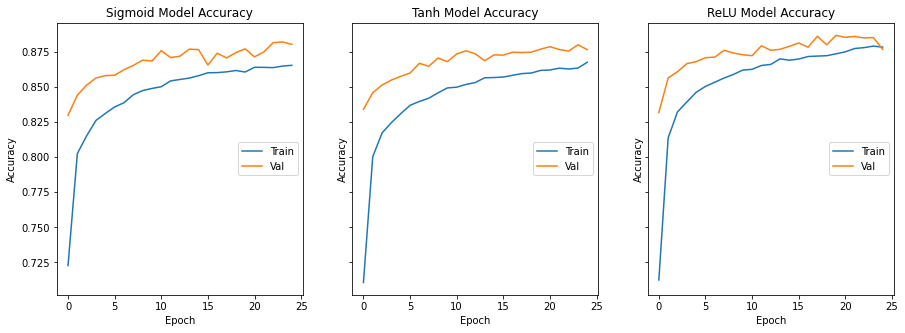

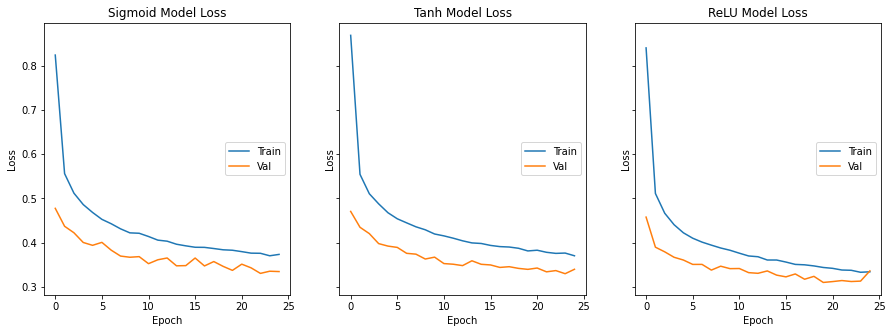

In [9]:
# Representación de las accuracies de los modelos entrenados
plot_acc(
    histories=[history_sigmoid, history_tanh, history_relu],
    titles=['Sigmoid', 'Tanh', 'ReLU']
)

# Representación de las pérdidas de los modelos entrenados
plot_loss(
    histories=[history_sigmoid, history_tanh, history_relu],
    titles=['Sigmoid', 'Tanh', 'ReLU']
)

Aunque las tres unidades de activación siguen un patrón muy similar, puede verse que la convergencia de la unidad `relu` es más rápida desde el inicio. Por lo que en un entrenamiento donde el número de épocas fuese muy limitado cabría esperar que la diferencia entre las tres funciones de activación fuese mayor que la mostrada en este ejemplo.

No obstante, también debe mencionarse que la función `relu` presenta un comportamiento más 'nervioso' que las otras funciones lo que hace que las condiciones de *early stopping* deban aplicarse con cuidado para no detener el entrenamiento antes de tiempo.

## 2. Inicialización de parámetros

Este apartado evalúa la importancia de una correcta inicialización de parámetros en una red neuronal.

Partiendo de una red similar a la del apartado anterior (usando ya ReLUs), se comentan las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, se inicializan todas las capas con las siguientes estrategias, disponibles en Keras, y se analizan sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

A continuación se procede a entrenar tres modelos idénticos pero variando la función de inicialización de los pesos de los parámetros de entrada de las neuronas.

En este caso, se usarán como [funciones de inicialización](https://keras.io/initializers/):

* `zeros`: que inicializa los pesos a 0.
* `random_normal`: que asigna valores aleatorios siguiendo una distribución normal.
* `glorot_uniform`: también conocida como distribución de Xavier uniforme, intenta que la varianza de salida sea igual que la de entrada.

In [10]:
# Inicialización con ceros
modelo_ceros, history_ceros = entrenar_modelo(x_train, y_train, kernel_initializer='zeros')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'zeros'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.1000
  - Loss Train: 2.3034
  - Acc. Validation: 0.1003
  - Loss Validation: 2.3031
  - Mejor época: 14


In [11]:
# Inicialización con una variable aleatoria
modelo_aleatorio, history_aleatorio = entrenar_modelo(x_train, y_train, kernel_initializer='random_normal')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'random_normal'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8784
  - Loss Train: 0.3326
  - Acc. Validation: 0.8861
  - Loss Validation: 0.3111
  - Mejor época: 00


In [12]:
# Inicialización con glorot
modelo_glorot, history_glorot = entrenar_modelo(x_train, y_train, kernel_initializer='glorot_uniform')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8780
  - Loss Train: 0.3332
  - Acc. Validation: 0.8890
  - Loss Validation: 0.3050
  - Mejor época: 00


#### Comparación de resultados y conclusiones

Como cabía esperar, los resultados obtenidos al entrenar el modelo inicializando los pesos de entrada de las neuronas a `0` son bastante malos, ya que se está imposibilitando que la red pueda aprender dado que todos los parámetros son iguales y esto hace que las salidas de todas las neuronas sean las mismas. Es necesario generar cierta asimetría inicial en la neuronas.

Si ahora se atiende a los otos dos modelos, puede verse que ambos ofrencen muy buenos resultados, siendo en este caso el mejor modelo el que se ha entrenado con la función de inicialización: `glorot_uniform` que asigna valores aleatorios siguiendo una distribución uniforme y procurando que la varianza de salida de las neuronas sea igual a la varianza de entrada.

Por tanto, queda seleccionado como `kernel` de inicialización la función `glorot_uniform` para el entrenamiento del modelo final.

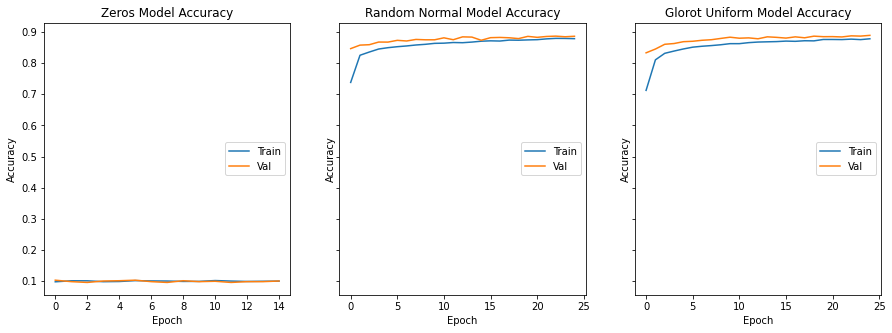

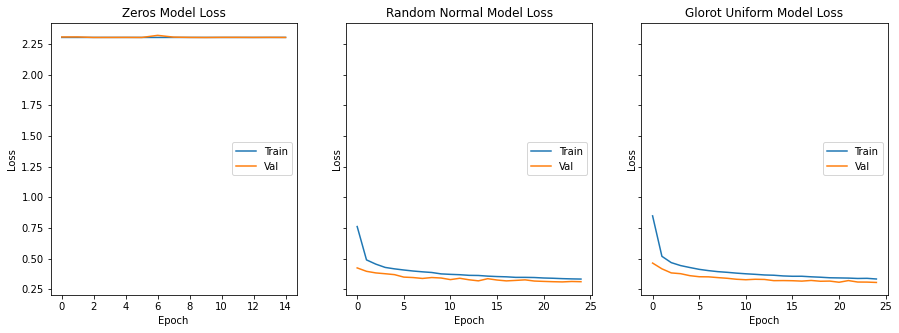

In [13]:
# Representación de las accuracies de los modelos entrenados
plot_acc(
    histories=[history_ceros, history_aleatorio, history_glorot],
    titles=['Zeros', 'Random Normal', 'Glorot Uniform']
)

# Representación de las pérdidas de los modelos entrenados
plot_loss(
    histories=[history_ceros, history_aleatorio, history_glorot],
    titles=['Zeros', 'Random Normal', 'Glorot Uniform']
)

Es interesante ver en la imagen como el *early stopping* ha detenido el entrenamiento en el caso de `zeros` al detectar que la *loss* en el set de validación comenzaba a empeorar según continuaba el entrenamiento del modelo.

## 3. Optimizadores

Partiendo de una red similar a la del apartado anterior (utilizando la mejor estrategia de inicialización observada), se comparan y analizan las diferencias que se observan al entrenar con varios de los optimizadores disponibles en Keras, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

Finalmente se procede a elegir entre una serie de [optimizadores](https://keras.io/optimizers/) aquel que mejor resultados proporcione:

- `sgd`: *Stochastic gradient descent*
- `RMSProp`
- `Adam`

In [14]:
# Inicialización con SGD
modelo_sgd, history_sgd = entrenar_modelo(x_train, y_train, optimizer='sgd')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'sgd'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8541
  - Loss Train: 0.4023
  - Acc. Validation: 0.8748
  - Loss Validation: 0.3538
  - Mejor época: 00


In [15]:
# Inicialización con RMSprop
modelo_rmsprop, history_rmsprop = entrenar_modelo(x_train, y_train, optimizer='rmsprop')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'rmsprop'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8789
  - Loss Train: 0.3418
  - Acc. Validation: 0.8808
  - Loss Validation: 0.3193
  - Mejor época: 00


In [16]:
# Inicialización con Adam
modelo_adam, history_adam = entrenar_modelo(x_train, y_train, optimizer='adam')

- Comienza entrenamiento con:
  - activation: 'relu'
  - kernel_initializer: 'glorot_uniform'
  - optimizer: 'adam'
  ... Fin del entrenamiento
- Métricas obtenidas en la mejor/última época:
  - Acc. Train: 0.8779
  - Loss Train: 0.3344
  - Acc. Validation: 0.8878
  - Loss Validation: 0.3086
  - Mejor época: 00


#### Comparación de resultados y conclusiones

Los tres optimizadores ofrecen resultados muy similares, aunque `sgd` queda ligeramente por detrás de los otros dos.

En este caso concreto `adam` ha dado mejores resultados que `rmsprop` por lo que el modelo final se entrenará teniendo en cuenta `adam` como función de optimización.

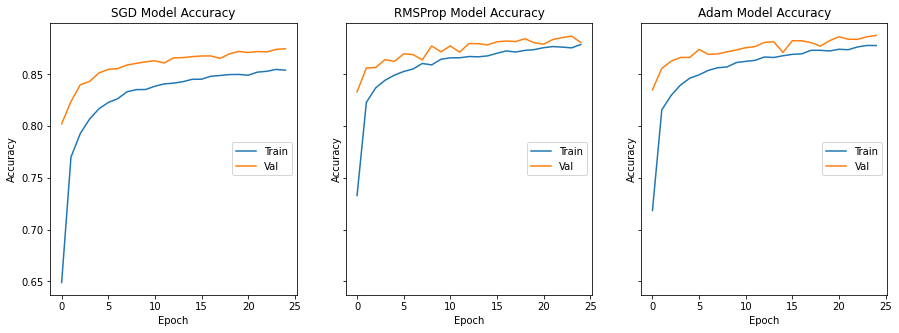

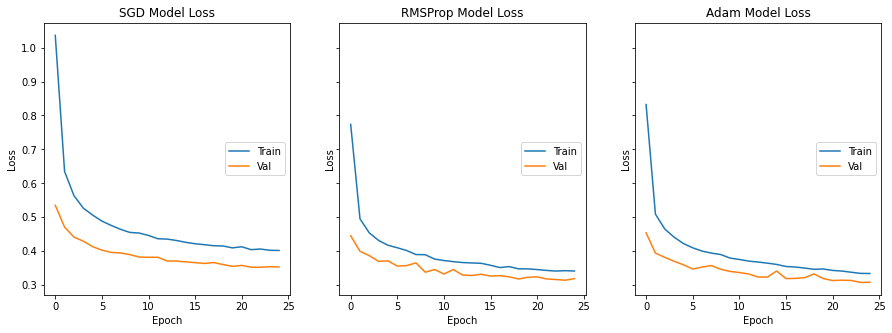

In [17]:
# Representación de las accuracies de los modelos entrenados
plot_acc(
    histories=[history_sgd, history_rmsprop, history_adam],
    titles=['SGD', 'RMSProp', 'Adam']
)

# Representación de las pérdidas de los modelos entrenados
plot_loss(
    histories=[history_sgd, history_rmsprop, history_adam],
    titles=['SGD', 'RMSProp', 'Adam']
)

## 4. Regularización y red final

Ahora entrenaremos una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinaremos todo lo aprendido anteriormente y se utilizarán técnicas de regularización para evitar overfitting. Algunos elementos que se tendrán en cuenta son los siguientes:

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

De todas las pruebas anteriores, podemos concluir que los parámetros que ofrecen mejores resultados de la red son:

- Función de activación: `relu`
- Inicialización de valores: `glorot_uniform`
- Optimizador: `adam`

En base a estos parámetros se entrenará ahora un nuevo modelo teniendo en cuenta todos los datos disponibles en el set (`x_train`, `y_train`) dado que en los entrenamientos anteriores un porcentaje de esos datos (un 20% concretamente) se destinaba a la validación del entrenamiento.

In [18]:
modelo_final, history_final = entrenar_modelo(
    x_train, y_train,
    activation='relu',
    kernel_initializer='glorot_uniform',
    optimizer='adam',
    porc_validacion=0,
    show_only_summary=False
)

Epoch 1/25
60000/60000 [==============================] - 19s 314us/step - loss: 0.7837 - acc: 0.7356
Epoch 2/25
60000/60000 [==============================] - 15s 254us/step - loss: 0.4925 - acc: 0.8214
Epoch 3/25
60000/60000 [==============================] - 15s 255us/step - loss: 0.4524 - acc: 0.8346
Epoch 4/25
60000/60000 [==============================] - 15s 255us/step - loss: 0.4259 - acc: 0.8447
Epoch 5/25
60000/60000 [==============================] - 15s 255us/step - loss: 0.4126 - acc: 0.8492
Epoch 6/25
60000/60000 [==============================] - 15s 254us/step - loss: 0.4048 - acc: 0.8521
Epoch 7/25
60000/60000 [==============================] - 15s 254us/step - loss: 0.3968 - acc: 0.8568
Epoch 8/25
60000/60000 [==============================] - 15s 255us/step - loss: 0.3873 - acc: 0.8595
Epoch 9/25
60000/60000 [==============================] - 15s 256us/step - loss: 0.3801 - acc: 0.8626
Epoch 10/25
60000/60000 [==============================] - 15s 256us/step - loss: 

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

A continuación se usan los datos reservados inicialmente para *test* con el fin de determinar cómo de bueno ha sido el modelo construido y entrenado en base a los parámetros seleccionados.

In [19]:
loss, accuracy = modelo_final.evaluate(x_test, y_test, verbose=False)

print("Loss Test: {:0.4f}".format(loss))
print("Accuracy Test: {:0.4f}".format(accuracy))

Loss Test: 0.3235
Accuracy Test: 0.8846


Como puede verse, la *accuracy* obtenida está proxima al 90% lo que permite concluir que el modelo entrenado es válido para clasificar los elementos del conjunto de datos de *Fashion MNIST*.